# TD3 CNN CarRacing-v3 Evaluation

This notebook loads the trained TD3 CNN model and evaluates it on CarRacing-v3 for 100 episodes with visualization and video recording.

## Import Libraries and Define Classes

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
from collections import deque
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [27]:
def preprocess_frame(frame):
    """Preprocess CarRacing frame: grayscale and normalize"""
    gray = 0.299 * frame[:, :, 0] + 0.587 * frame[:, :, 1] + 0.114 * frame[:, :, 2]
    normalized = gray / 255.0
    return normalized.astype(np.float32)


class FrameStack:
    """Stack consecutive frames for temporal information"""
    def __init__(self, num_frames=4):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self, frame):
        processed = preprocess_frame(frame)
        for _ in range(self.num_frames):
            self.frames.append(processed)
        return self.get_state()
    
    def update(self, frame):
        processed = preprocess_frame(frame)
        self.frames.append(processed)
        return self.get_state()
    
    def get_state(self):
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)

## Define CNN Actor and Critic Networks

In [28]:
class CNNActor(nn.Module):
    def __init__(self, num_frames, action_dim, max_action):
        super(CNNActor, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        conv_output_size = 64 * 8 * 8
        
        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # Split actions: steering (tanh), gas (sigmoid), brake (sigmoid)
        steering = torch.tanh(x[:, 0:1])
        gas = torch.sigmoid(x[:, 1:2])
        brake = torch.sigmoid(x[:, 2:3])
        
        return torch.cat([steering, gas, brake], dim=1)


class CNNCritic(nn.Module):
    def __init__(self, num_frames, action_dim):
        super(CNNCritic, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        conv_output_size = 64 * 8 * 8
        
        # Fully connected layers (state + action)
        self.fc1 = nn.Linear(conv_output_size + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        
        # Concatenate with action
        x = torch.cat([x, action], 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Define TD3 CNN Agent

In [29]:
class TD3_CNN(object):
    def __init__(self, num_frames, action_dim, max_action):
        self.actor = CNNActor(num_frames, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        
        self.critic_1 = CNNCritic(num_frames, action_dim).to(device)
        self.critic_1_target = copy.deepcopy(self.critic_1)
        
        self.critic_2 = CNNCritic(num_frames, action_dim).to(device)
        self.critic_2_target = copy.deepcopy(self.critic_2)
        
        self.max_action = max_action

    def select_action(self, state):
        # state shape: (num_frames, H, W)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)  # Add batch dimension
        action = self.actor(state).cpu().detach().numpy().flatten()
        return np.clip(action, -self.max_action, self.max_action)
    
    def load(self, filename):
        self.actor.load_state_dict(torch.load(filename + "_actor.pth", map_location=device))
        self.critic_1.load_state_dict(torch.load(filename + "_critic_1.pth", map_location=device))
        self.critic_2.load_state_dict(torch.load(filename + "_critic_2.pth", map_location=device))
        
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_1_target = copy.deepcopy(self.critic_1)
        self.critic_2_target = copy.deepcopy(self.critic_2)
        
        self.actor.eval()
        self.critic_1.eval()
        self.critic_2.eval()

## Load Trained Model

In [30]:
env_name = "CarRacing-v3"
num_frames = 4

# Create environment for testing
env = gym.make(env_name, render_mode=None)

action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

print(f"Environment: {env_name}")
print(f"Action dimension: {action_dim}")
print(f"Max action: {max_action}")
print(f"Num frames: {num_frames}")

# Create agent
agent = TD3_CNN(
    num_frames=num_frames,
    action_dim=action_dim, 
    max_action=max_action
)

# Load trained model
model_path = "./TD3-models/car_racing/"
if os.path.exists(model_path + "_actor.pth"):
    agent.load(model_path)
    print(f"\n✓ Model loaded successfully from {model_path}")
else:
    print(f"\n✗ ERROR: Model not found at {model_path}")
    print("Make sure to train the model first using TD3_CNN.py")

Environment: CarRacing-v3
Action dimension: 3
Max action: 1.0
Num frames: 4

✓ Model loaded successfully from ./TD3-models/car_racing/

✓ Model loaded successfully from ./TD3-models/car_racing/


## Evaluate for 100 Episodes

In [31]:
num_eval_episodes = 100
eval_rewards = []
eval_episode_lengths = []
frame_stack = FrameStack(num_frames)

print(f"Running {num_eval_episodes} evaluation episodes...")
print("="*70)

for episode in range(num_eval_episodes):
    frame, _ = env.reset()
    state = frame_stack.reset(frame)
    done = False
    episode_reward = 0
    episode_length = 0
    
    while not done:
        action = agent.select_action(state)
        next_frame, reward, terminated, truncated, _ = env.step(action)
        state = frame_stack.update(next_frame)
        done = terminated or truncated
        
        episode_reward += reward
        episode_length += 1
    
    eval_rewards.append(episode_reward)
    eval_episode_lengths.append(episode_length)
    
    #if (episode + 1) % 10 == 0:
    print(f"Episode {episode + 1:3d}/{num_eval_episodes} | "
            f"Reward: {episode_reward:7.2f} | Steps: {episode_length:4d}")

env.close()
print("="*70)
print("Evaluation complete!")

Running 100 evaluation episodes...


KeyboardInterrupt: 

## Display Statistics

In [ ]:
# Calculate statistics
mean_reward = np.mean(eval_rewards)
std_reward = np.std(eval_rewards)
min_reward = np.min(eval_rewards)
max_reward = np.max(eval_rewards)
median_reward = np.median(eval_rewards)

mean_length = np.mean(eval_episode_lengths)
std_length = np.std(eval_episode_lengths)

print("\n" + "="*70)
print("EVALUATION RESULTS - TD3 CNN on CarRacing-v3")
print("="*70)
print(f"Number of episodes: {num_eval_episodes}")
print(f"\nReward Statistics:")
print(f"  Mean:   {mean_reward:8.2f} ± {std_reward:.2f}")
print(f"  Median: {median_reward:8.2f}")
print(f"  Min:    {min_reward:8.2f}")
print(f"  Max:    {max_reward:8.2f}")
print(f"\nEpisode Length:")
print(f"  Mean:   {mean_length:8.2f} ± {std_length:.2f}")
print(f"\nSuccess Metrics:")
print(f"  Episodes > 400: {sum(1 for r in eval_rewards if r > 400):3d} ({sum(1 for r in eval_rewards if r > 400)/len(eval_rewards)*100:.1f}%)")
print(f"  Episodes > 500: {sum(1 for r in eval_rewards if r > 500):3d} ({sum(1 for r in eval_rewards if r > 500)/len(eval_rewards)*100:.1f}%)")
print(f"  Episodes > 600: {sum(1 for r in eval_rewards if r > 600):3d} ({sum(1 for r in eval_rewards if r > 600)/len(eval_rewards)*100:.1f}%)")
print("="*70)


EVALUATION RESULTS - TD3 CNN on CarRacing-v3
Number of episodes: 10

Reward Statistics:
  Mean:     181.51 ± 111.46
  Median:   169.55
  Min:       18.64
  Max:      339.02

Episode Length:
  Mean:    1000.00 ± 0.00

Success Metrics:
  Episodes > 400:   0 (0.0%)
  Episodes > 500:   0 (0.0%)
  Episodes > 600:   0 (0.0%)


## Visualize Results

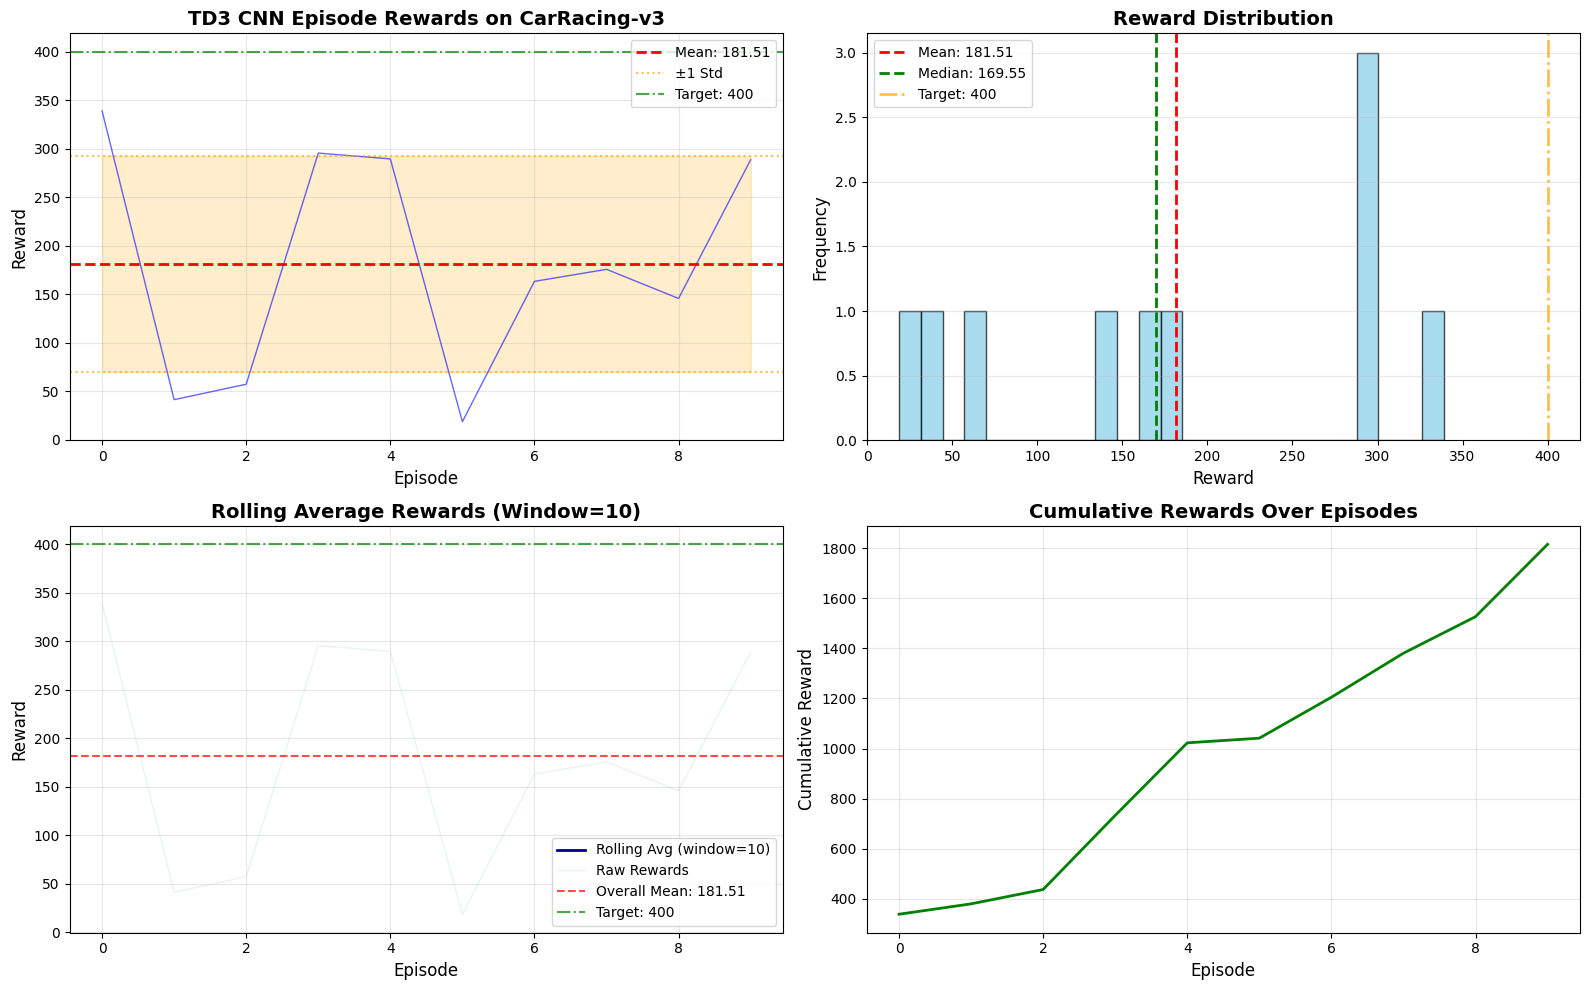

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Rewards over episodes
axes[0, 0].plot(eval_rewards, alpha=0.6, linewidth=1, color='blue')
axes[0, 0].axhline(y=mean_reward, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_reward:.2f}')
axes[0, 0].axhline(y=mean_reward + std_reward, color='orange', linestyle=':', alpha=0.7, label=f'±1 Std')
axes[0, 0].axhline(y=mean_reward - std_reward, color='orange', linestyle=':', alpha=0.7)
axes[0, 0].axhline(y=400, color='green', linestyle='-.', linewidth=1.5, alpha=0.7, label='Target: 400')
axes[0, 0].fill_between(range(len(eval_rewards)), 
                         mean_reward - std_reward, 
                         mean_reward + std_reward, 
                         alpha=0.2, color='orange')
axes[0, 0].set_xlabel('Episode', fontsize=12)
axes[0, 0].set_ylabel('Reward', fontsize=12)
axes[0, 0].set_title('TD3 CNN Episode Rewards on CarRacing-v3', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Reward distribution histogram
axes[0, 1].hist(eval_rewards, bins=25, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].axvline(x=mean_reward, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_reward:.2f}')
axes[0, 1].axvline(x=median_reward, color='g', linestyle='--', linewidth=2, label=f'Median: {median_reward:.2f}')
axes[0, 1].axvline(x=400, color='orange', linestyle='-.', linewidth=2, alpha=0.7, label='Target: 400')
axes[0, 1].set_xlabel('Reward', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Reward Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Rolling average (window=10)
window = 10
rolling_avg = np.convolve(eval_rewards, np.ones(window)/window, mode='valid')
axes[1, 0].plot(range(window-1, len(eval_rewards)), rolling_avg, linewidth=2, color='darkblue', label=f'Rolling Avg (window={window})')
axes[1, 0].plot(eval_rewards, alpha=0.3, linewidth=1, color='lightblue', label='Raw Rewards')
axes[1, 0].axhline(y=mean_reward, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Overall Mean: {mean_reward:.2f}')
axes[1, 0].axhline(y=400, color='green', linestyle='-.', linewidth=1.5, alpha=0.7, label='Target: 400')
axes[1, 0].set_xlabel('Episode', fontsize=12)
axes[1, 0].set_ylabel('Reward', fontsize=12)
axes[1, 0].set_title(f'Rolling Average Rewards (Window={window})', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative reward
cumulative_rewards = np.cumsum(eval_rewards)
axes[1, 1].plot(cumulative_rewards, linewidth=2, color='green')
axes[1, 1].set_xlabel('Episode', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Reward', fontsize=12)
axes[1, 1].set_title('Cumulative Rewards Over Episodes', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

## Record Video of High-Scoring Episode (Reward > 400)

In [ ]:
print("\n" + "="*70)
print("Recording video of high-scoring episodes (reward > 400)...")
print("="*70)

# Create video directory
video_dir = "./TD3-models/car_racing"
os.makedirs(video_dir, exist_ok=True)

# Create environment with video recording
def make_video_env(video_folder, episode_trigger):
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=episode_trigger)
    return env

# Record episodes until we get one with reward > 400
max_attempts = 50
recorded_episodes = []
frame_stack_video = FrameStack(num_frames)

for attempt in range(max_attempts):
    # Create fresh environment for each attempt
    video_env = make_video_env(video_dir, lambda x: True)
    
    frame, _ = video_env.reset()
    state = frame_stack_video.reset(frame)
    done = False
    episode_reward = 0
    episode_length = 0
    
    while not done:
        action = agent.select_action(state)
        next_frame, reward, terminated, truncated, _ = video_env.step(action)
        state = frame_stack_video.update(next_frame)
        done = terminated or truncated
        
        episode_reward += reward
        episode_length += 1
    
    video_env.close()
    
    if episode_reward > 400:
        recorded_episodes.append({
            'attempt': attempt + 1,
            'reward': episode_reward,
            'length': episode_length
        })
        print(f"✓ Recorded episode {len(recorded_episodes)}: Reward = {episode_reward:.2f}, Steps = {episode_length}")
        
        if len(recorded_episodes) >= 1:  # Record up to 1 good episode
            break
    else:
        print(f"  Attempt {attempt + 1}: Reward = {episode_reward:.2f} (< 400, skipping)", end='\r')

print("\n" + "="*70)
if recorded_episodes:
    print(f"Successfully recorded {len(recorded_episodes)} episode(s) with reward > 400")
    print(f"Videos saved to: {video_dir}/")
    for i, ep in enumerate(recorded_episodes, 1):
        print(f"  Episode {i}: Reward = {ep['reward']:.2f}, Steps = {ep['length']}")
else:
    print("No episodes with reward > 400 found in the attempts.")
    print(f"Consider lowering the threshold or running more attempts.")
print("="*70)


Recording video of high-scoring episodes (reward > 400)...


c:\Users\a\anaconda3\envs\ml\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\a\OneDrive\Desktop\Fall 2025\Reinforcement Learning\assignments\Reinforcement-Learning\Assignment 4 - SOTA model-free algorithms\TD3-models\car_racing folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✓ Recorded episode 1: Reward = 406.85, Steps = 1000

Successfully recorded 1 episode(s) with reward > 400
Videos saved to: ./TD3-models/car_racing/
  Episode 1: Reward = 406.85, Steps = 1000
✓ Recorded episode 1: Reward = 406.85, Steps = 1000

Successfully recorded 1 episode(s) with reward > 400
Videos saved to: ./TD3-models/car_racing/
  Episode 1: Reward = 406.85, Steps = 1000
